### **Práctica: Generación de Rostros con VAE usando CelebA**  
**Objetivo**: Entrenar un Variational Autoencoder (VAE) convolucional para generar rostros nuevos a partir del dataset CelebA.  

---

### **1. Configuración Inicial**  
**Objetivo**: Preparar el entorno y el dataset.  

**Instrucciones**:  

1. **Descargar CelebA**:  
   - El dataset contiene ~200k imágenes de rostros.  
   - Utilizar `kagglehub` para descargar el dataset directamente desde Kaggle.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

/mnt/c/Users/aleja/Desktop/Master/05 - IA Generativa/Desarrollo/CasoEstudio-GenerarRostros/.venvWSL/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/aleja/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2


2. **Preprocesamiento**:  
   - Redimensionar imágenes a 64x64 píxeles (si no están ya en ese tamaño).  
   - Normalizar píxeles al rango `[0, 1]`.  

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

# Path to the dataset
img_dir = os.path.join(path, 'img_align_celeba/img_align_celeba')

# Check if the directory exists
if not os.path.exists(img_dir):
    img_dir = os.path.join(path, 'img_align_celeba', 'img_align_celeba')
    if not os.path.exists(img_dir):
        print(f"Could not find the images directory. Available files in {path}:")
        print(os.listdir(path))

# List all image files
image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')]
print(f"Total number of images found: {len(image_files)}")

# Function to preprocess images
def preprocess_image(img_path, target_size=(64, 64)):
    # Load and resize image
    img = Image.open(img_path)
    img = img.resize(target_size, Image.LANCZOS)
    
    # Convert to numpy array and normalize to [0, 1]
    img_array = np.array(img).astype('float32') / 255.0
    
    return img_array

# Create a sample of images to process (limit to 5000 images to save memory)
sample_size = min(5000, len(image_files))
sample_files = image_files[:sample_size]

# Process the sampled images
processed_images = []

# Simple progress tracking
start_time = time.time()
update_interval = max(1, sample_size // 20)  # Update every 5% of progress
print(f"Processing {sample_size} images...")

for i, img_file in enumerate(sample_files):
    img_path = os.path.join(img_dir, img_file)
    processed_img = preprocess_image(img_path)
    processed_images.append(processed_img)
    
    # Print progress update
    if (i + 1) % update_interval == 0 or i == sample_size - 1:
        progress = (i + 1) / sample_size * 100
        elapsed = time.time() - start_time
        remaining = elapsed / (i + 1) * (sample_size - i - 1) if i > 0 else 0
        print(f"Progress: {progress:.1f}% ({i+1}/{sample_size}) - Elapsed: {elapsed:.1f}s - Est. remaining: {remaining:.1f}s")

# Convert to numpy array
processed_images = np.array(processed_images)
print(f"Processing completed in {time.time() - start_time:.1f} seconds")
print(f"Processed images shape: {processed_images.shape}")
print(f"Min value: {processed_images.min()}, Max value: {processed_images.max()}")

Total number of images found: 202599
Processing 5000 images...
Progress: 5.0% (250/5000) - Elapsed: 0.4s - Est. remaining: 6.8s
Progress: 5.0% (250/5000) - Elapsed: 0.4s - Est. remaining: 6.8s
Progress: 10.0% (500/5000) - Elapsed: 0.6s - Est. remaining: 5.2s
Progress: 10.0% (500/5000) - Elapsed: 0.6s - Est. remaining: 5.2s
Progress: 15.0% (750/5000) - Elapsed: 0.8s - Est. remaining: 4.4s
Progress: 20.0% (1000/5000) - Elapsed: 1.0s - Est. remaining: 3.9s
Progress: 15.0% (750/5000) - Elapsed: 0.8s - Est. remaining: 4.4s
Progress: 20.0% (1000/5000) - Elapsed: 1.0s - Est. remaining: 3.9s
Progress: 25.0% (1250/5000) - Elapsed: 1.2s - Est. remaining: 3.5s
Progress: 30.0% (1500/5000) - Elapsed: 1.4s - Est. remaining: 3.2s
Progress: 25.0% (1250/5000) - Elapsed: 1.2s - Est. remaining: 3.5s
Progress: 30.0% (1500/5000) - Elapsed: 1.4s - Est. remaining: 3.2s
Progress: 35.0% (1750/5000) - Elapsed: 1.5s - Est. remaining: 2.9s
Progress: 40.0% (2000/5000) - Elapsed: 1.7s - Est. remaining: 2.6s
Progres

3. **Visualizar algunas imágenes procesadas**:  
   - Verifiquemos que las imágenes se han procesado correctamente.

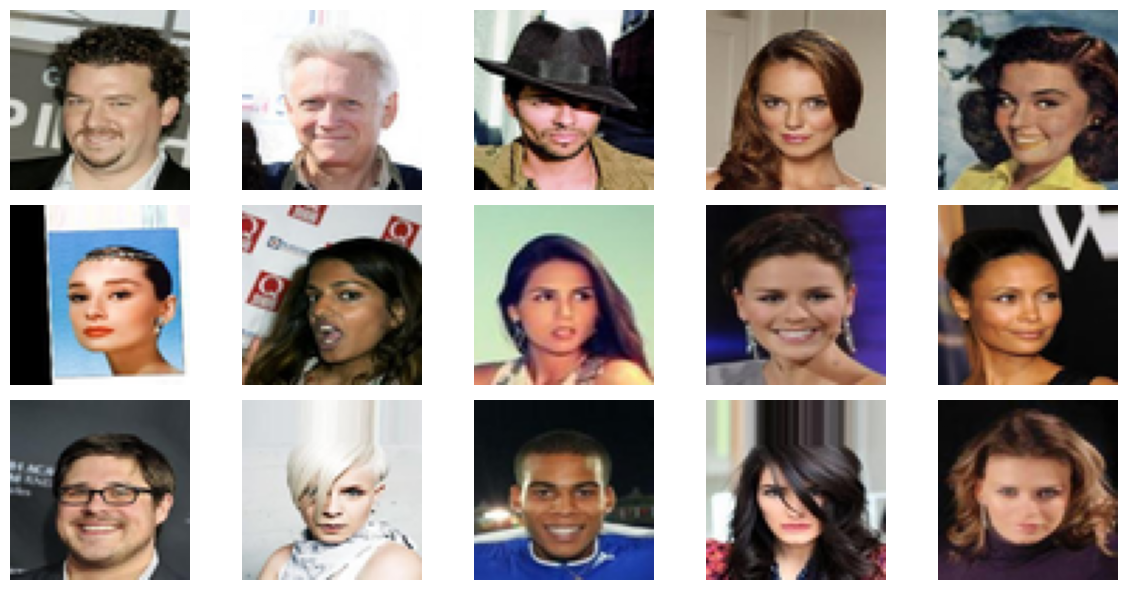

In [3]:
# Display a grid of processed sample images
plt.figure(figsize=(12, 6))
for i in range(15):  # Display 15 sample images
    plt.subplot(3, 5, i+1)
    plt.imshow(processed_images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

4. **Crear DataLoader**:  
   - Usar batches de 64-128 imágenes.  
   - *pista*: `tf.data.Dataset.from_tensor_slices` permite crear un pipeline eficiente.  

In [4]:
import tensorflow as tf

# Set batch size
batch_size = 64

# Split the data into training and validation sets (90% training, 10% validation)
train_size = int(0.9 * len(processed_images))
train_images = processed_images[:train_size]
val_images = processed_images[train_size:]

print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
val_dataset = tf.data.Dataset.from_tensor_slices(val_images)

# Configure the datasets for performance
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Verify the dataset shapes
for x_batch in train_dataset.take(1):
    print(f"Input batch shape: {x_batch.shape}")
    # Verify that the data is normalized properly
    print(f"Data range: [{tf.reduce_min(x_batch).numpy()}, {tf.reduce_max(x_batch).numpy()}]")

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")

2025-05-06 11:15:18.955942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 11:15:19.037553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746522919.056402   20809 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746522919.062048   20809 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746522919.092321   20809 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Training images: 4500, Validation images: 500


I0000 00:00:1746522963.873658   20809 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3620 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Input batch shape: (64, 64, 64, 3)
Data range: [0.0, 1.0]
Training batches: 71
Validation batches: 8


2025-05-06 11:16:04.641147: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---

### **2. Diseño del VAE Convolucional**  
**Objetivo**: Construir un VAE con encoder y decoder convolucionales.  

#### **Encoder**:  
- **Capas**:  
  - 4 capas convolucionales (`Conv2D`) con activación `LeakyReLU` o `ReLU`.  
  - Reducir dimensiones espaciales progresivamente (ej: 64x64 → 32x32 → 16x16).  
- **Capa Latente**:  
  - Dos salidas: `z_mean` y `z_log_var` (media y log-varianza de la distribución latente).  
  - Dimensión del espacio latente: 256.  
- *pista*: Usar `Flatten` antes de las capas densas para `z_mean` y `z_log_var`.  

#### **Reparameterization Trick**:  
- Muestrear `z` usando:  
  ```  
  z = z_mean + exp(z_log_var * 0.5) * epsilon  
  ```  
  donde `epsilon ~ N(0, 1)`.  

#### **Decoder**:  
- **Capas**:  
  - 4 capas `Conv2DTranspose` o `UpSampling2D + Conv2D` para aumentar resolución.  
  - Usar activación `sigmoid` en la última capa si las imágenes están en `[0, 1]`.  
- *pista*: Asegurar que la salida final tenga las mismas dimensiones que la entrada (64x64x3).  

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Set hyperparameters
latent_dim = 256  # Size of latent space
input_shape = (64, 64, 3)  # Shape of input images

# Create the encoder
def build_encoder(input_shape, latent_dim):
    encoder_inputs = layers.Input(shape=input_shape)
    
    # Convolutional layers with LeakyReLU activation
    x = layers.Conv2D(32, 4, strides=2, padding='same')(encoder_inputs)
    x = layers.LeakyReLU(0.2)(x)
    # 32x32x32
    
    x = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 16x16x64
    
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 8x8x128
    
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 4x4x256
    
    # Flatten the features
    x = layers.Flatten()(x)
    
    # Output layers for mean and log variance
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    
    # Create the encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder

# Reparameterization trick as a Keras layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch_size = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch_size, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Create the decoder
def build_decoder(latent_dim, output_shape):
    latent_inputs = layers.Input(shape=(latent_dim,))
    
    # Calculate dimensions for reshaping
    # For input images of 64x64, after 4 layers of Conv2D with stride 2, we get 4x4
    units = 4 * 4 * 256  # Width * Height * Channels
    
    # Dense layer and reshape
    x = layers.Dense(units)(latent_inputs)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((4, 4, 256))(x)
    # 4x4x256
    
    # Transposed convolution layers to increase resolution
    x = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 8x8x128
    
    x = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 16x16x64
    
    x = layers.Conv2DTranspose(32, 4, strides=2, padding='same')(x)
    x = layers.LeakyReLU(0.2)(x)
    # 32x32x32
    
    # Final layer with sigmoid activation for output in range [0, 1]
    decoder_outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')(x)
    # 64x64x3
    
    # Create the decoder model
    decoder = Model(latent_inputs, decoder_outputs, name='decoder')
    return decoder

# Build the encoder
encoder = build_encoder(input_shape, latent_dim)
encoder.summary()

# Build the decoder
decoder = build_decoder(latent_dim, input_shape)
decoder.summary()

# Define the VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = tf.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf.keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = self.sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        return reconstructed
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get encoder outputs
            z_mean, z_log_var = self.encoder(data)
            # Sample from the latent distribution
            z = self.sampling([z_mean, z_log_var])
            # Decode the sampled vector
            reconstructed = self.decoder(z)
            
            # Calculate reconstruction loss (pixel-wise binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed),
                    axis=(1, 2)
                )
            )
            
            # Calculate KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            
            # Total loss is the sum of reconstruction loss and KL loss
            total_loss = reconstruction_loss + kl_loss
        
        # Get gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        # Return metrics dictionary
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result()
        }

# Create the VAE model
vae = VAE(encoder, decoder)

# Compile the model
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001))

# Display the model architecture summary
print("VAE Architecture Created Successfully")

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │      1,568 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     32,832 │ leaky_re_lu[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 16, 16,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 128) │    131,200 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 8, 8, 128) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 4, 4, 256) │    524,544 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 4, 4, 256) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 256)       │  1,048,832 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,787,808 (10.63 MB)

 Trainable params: 2,787,808 (10.63 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        32,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         1,539 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,742,563 (6.65 MB)

 Trainable params: 1,742,563 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

VAE Architecture Created Successfully
